In [1]:
# Standard Library
import os
import sys
import json
import pandas as pd
import numpy as np
from pathlib import Path

# Add src directory to Python path
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

# Project Modules
from modeling.data_modeling import (
    train_ranker,
    predict_rankings,
    save_model,
    get_feature_importance,
    split_data
)
from evaluation.evaluation import calculate_mrr
from featureEngineering.feature_engineering import feature_engineering

# Configuration
INTERMEDIATE_DIR = "intermediate"
STUDENT_ID = "22127XXX"  # TODO: Change to your student ID
OUTPUT_DIR = f"../{STUDENT_ID}"

print("All imports loaded successfully")

All imports loaded successfully


---

## **STEP 1 - Load Data**

In [2]:
"""
STEP 1: Load Data
==================
"""

# Load labeled dataset
labeled_path = Path(INTERMEDIATE_DIR) / "labeled_dataset.csv"
if not labeled_path.exists():
    raise FileNotFoundError(f"File not found: {labeled_path}. Run Notebook 02 first!")

df_labeled = pd.read_csv(labeled_path)

# Summary
print(f"{'='*60}")
print(f"STEP 1: Data Loading Complete")
print(f"{'='*60}")
print(f"  Total samples: {len(df_labeled)}")
print(f"  Positive (label=1): {(df_labeled['label'] == 1).sum()}")
print(f"  Negative (label=0): {(df_labeled['label'] == 0).sum()}")
print(f"  Columns: {list(df_labeled.columns)}")
print(f"{'='*60}")

df_labeled.head()

STEP 1: Data Loading Complete
  Total samples: 430
  Positive (label=1): 215
  Negative (label=0): 215
  Columns: ['pub_id', 'bib_key', 'bib_ref_id', 'bib_title_clean', 'bib_authors_clean', 'bib_author_tokens', 'bib_year', 'candidate_arxiv_id', 'candidate_title_clean', 'candidate_authors_clean', 'candidate_author_tokens', 'candidate_year', 'label', 'confidence_score', 'title_score', 'author_score', 'year_score', 'source']


,pub_id,bib_key,bib_ref_id,bib_title_clean,bib_authors_clean,bib_author_tokens,bib_year,candidate_arxiv_id,candidate_title_clean,candidate_authors_clean,candidate_author_tokens,candidate_year,label,confidence_score,title_score,author_score,year_score,source
0,2211-13769,vaswani2017attention,REF-001692,attention need,"vaswani a, shazeer n, parmar n, uszkoreit j, j...","[['ashish', 'vaswani'], ['noam', 'shazeer'], [...",2017.0,1706-03762,attention need,"vaswani a, shazeer n, parmar n, uszkoreit j, j...","[['ashish', 'vaswani'], ['noam', 'm', 'shazeer...",2017,1,0.965000,1.000000,0.90,1.0,automatic
1,2211-13752,choi2021ilvr,REF-000281,ilvr conditioning method denoising diffusion p...,"choi j, kim s, jeong y, gwon y, yoon s","[['jooyoung', 'choi'], ['sungwon', 'kim'], ['y...",2021.0,2006-11239,denoising diffusion probabilistic model,"ho j, jain a, abbeel p","[['jonathan', 'ho'], ['ajay', 'jain'], ['p', '...",2020,0,0.478641,0.757282,0.00,0.5,automatic
2,2211-13757,ddpm,REF-000455,denoising diffusion probabilistic model,"ho j, jain a, abbeel p","[['jonathan', 'ho'], ['ajay', 'jain'], ['piete...",2020.0,2103-01458,diffusion probabilistic model 3d point cloud g...,"luo s, hu w","[['shitong', 'luo'], ['wei', 'hu']]",2021,0,0.408511,0.617021,0.00,0.5,automatic
3,2211-13767,Crosson_2021,REF-001535,prospect quantum enhancement diabatic quantum ...,"crosson e, lidar d",[],NaN,1505-01249,diabatic trump adiabatic quantum optimization,"muthukrishnan s, albash t, lidar d","[['siddharth', 'muthukrishnan'], ['t', 'albash...",2015,0,0.315000,0.480000,0.25,0.0,manual
4,2211-13771,hendrycks2019robustness,REF-001758,benchmarking neural network robustness common ...,"hendrycks d, dietterich t","[['dan', 'hendrycks'], ['thomas', 'dietterich']]",2019.0,1906-04659,stable rank normalization improved generalizat...,"sanyal a, torr p, dokania p","[['amartya', 'sanyal'], ['philip', 'h s', 'tor...",2019,0,0.366667,0.333333,0.00,1.0,automatic


---

## **STEP 2 - Feature Engineering**

In [3]:
"""
STEP 2: Feature Engineering
============================
Create features from labeled dataset.
"""

# Apply feature engineering
df_features = feature_engineering(df_labeled)

# Save featured dataset
featured_path = Path(INTERMEDIATE_DIR) / "featured_dataset.csv"
df_features.to_csv(featured_path, index=False)

# Summary
# Check for NaN/Inf
print(f"NaN values: {df_features.isna().sum().sum()}")
print(f"Inf values: {np.isinf(df_features.select_dtypes(include=[np.number])).sum().sum()}")


print(f"{'='*60}")
print(f"STEP 2: Feature Engineering Complete")
print(f"{'='*60}")
print(f"  Total samples: {len(df_features)}")
print(f"  Features created: {len([c for c in df_features.columns if c not in ['label', 'pub_id', 'bib_ref_id', 'candidate_arxiv_id']])}")
print(f"  Saved to: {featured_path}")
print(f"{'='*60}")

# Show feature columns
print("\n Feature columns:")
for col in df_features.columns:
    print(f"   - {col}")

df_features.head()

NaN values: 0
Inf values: 0
STEP 2: Feature Engineering Complete
  Total samples: 430
  Features created: 6
  Saved to: intermediate\featured_dataset.csv

 Feature columns:
   - label
   - pub_id
   - bib_ref_id
   - candidate_arxiv_id
   - source
   - Title_Soft_Jaccard
   - Title_Lev_Ratio
   - Author_Overlap_Score
   - Author_Levenshtein_Ratio
   - Year_Diff


,label,pub_id,bib_ref_id,candidate_arxiv_id,source,Title_Soft_Jaccard,Title_Lev_Ratio,Author_Overlap_Score,Author_Levenshtein_Ratio,Year_Diff
0,1,2211-13769,REF-001692,1706-03762,automatic,1.000000,0,0.0,0.0,0.0
1,0,2211-13752,REF-000281,2006-11239,automatic,0.571429,25,0.0,0.0,1.0
2,0,2211-13757,REF-000455,2103-01458,automatic,0.375000,16,0.0,0.0,1.0
3,0,2211-13767,REF-001535,1505-01249,manual,0.222222,10,0.0,0.0,-1.0
4,0,2211-13771,REF-001758,1906-04659,automatic,0.153846,0,0.0,0.0,0.0


---

## **STEP 3 - Train/Valid/Test Split**

In [4]:
"""
STEP 3: Train/Valid/Test Split
================================
Split dataset into Train, Validation, and Test sets.
"""

# Get paper IDs for manual and automatic sources
manual_pub_ids = df_features[df_features['source'] == 'manual']['pub_id'].unique().tolist()
auto_pub_ids = df_features[df_features['source'] == 'automatic']['pub_id'].unique().tolist()

print(f"Manual labeled publications: {len(manual_pub_ids)}")
print(f"Automatic labeled publications: {len(auto_pub_ids)}")

# Split data
df_train, df_val, df_test = split_data(df_features, manual_pub_ids=manual_pub_ids, auto_pub_ids=auto_pub_ids)

train_path = Path(INTERMEDIATE_DIR) / "train_dataset.csv"
val_path = Path(INTERMEDIATE_DIR) / "val_dataset.csv"
test_path = Path(INTERMEDIATE_DIR) / "test_dataset.csv"
df_train.to_csv(train_path, index=False)
df_val.to_csv(val_path, index=False)
df_test.to_csv(test_path, index=False)

# Summary
print(f"\n{'='*60}")
print(f"STEP 3: Data Split Complete")
print(f"{'='*60}")
print(f"  Train: {len(df_train)} samples ({df_train['pub_id'].nunique()} pubs)")
print(f"  Valid: {len(df_val)} samples ({df_val['pub_id'].nunique()} pubs)")
print(f"  Test:  {len(df_test)} samples ({df_test['pub_id'].nunique()} pubs)")
print(f"{'='*60}")

Manual labeled publications: 5
Automatic labeled publications: 13
Split summary:
  Train: 266 rows, 10 publications
  Valid: 98 rows, 2 publications
  Test:  66 rows, 2 publications

STEP 3: Data Split Complete
  Train: 266 samples (10 pubs)
  Valid: 98 samples (2 pubs)
  Test:  66 samples (2 pubs)


---

## **STEP 4 - Model Training**

In [ ]:
"""
STEP 4: Model Training
=======================
"""
# Define feature columns
FEATURE_COLS = [
    # Title features
    "Title_Soft_Jaccard",
    "Title_Length_Diff",
    # Author features
    "Author_Overlap_Score",
    "Author_Levenshtein_Ratio",
    # Year features
    "Year_Diff"
]

# Get available features in the DataFrame
available_features = [f for f in FEATURE_COLS if f in df_train.columns]
print(f"Using {len(available_features)} features: {available_features}")

TARGET = "label"

model = train_ranker(df_train, df_val, features=available_features, target=TARGET)

# Save model
model_path = save_model(model, INTERMEDIATE_DIR, filename="xgb_ranker.joblib")

print(f"\n{'='*60}")
print(f"STEP 4: Training Complete")
print(f"{'='*60}")

Using 5 features: ['Title_Soft_Jaccard', 'Title_Lev_Ratio', 'Author_Overlap_Score', 'Author_Levenshtein_Ratio', 'Year_Diff']
Best iteration: 0
Best score: 1.0
Model saved to: intermediate\xgb_ranker.joblib

STEP 4: Training Complete



Feature Importance:
                 feature  importance
      Title_Soft_Jaccard    0.976855
         Title_Lev_Ratio    0.012791
               Year_Diff    0.010353
    Author_Overlap_Score    0.000000
Author_Levenshtein_Ratio    0.000000


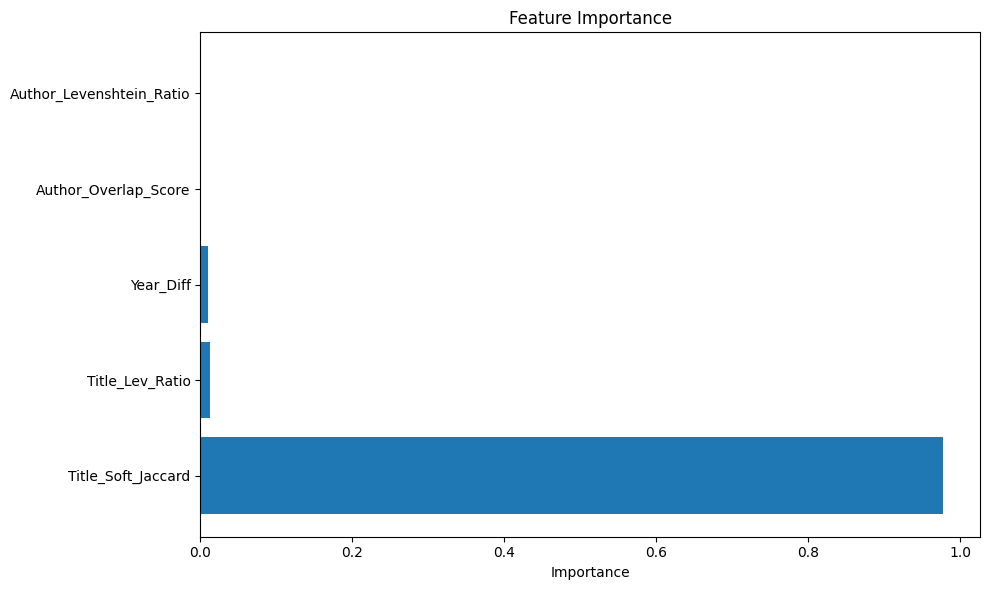

In [6]:
# Feature Importance
print("\nFeature Importance:")
importance_df = get_feature_importance(model, available_features)
print(importance_df.to_string(index=False))

# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [7]:
# 1. Kiểm tra distribution của features
# print(df_train[FEATURE_COLS].describe())

# 2. Correlation với label
print(df_train[FEATURE_COLS + ['label']].corr()['label'].sort_values(ascending=False))

# # 3. Kiểm tra variance
# print(df_train[FEATURE_COLS].var())

label                       1.000000
Title_Soft_Jaccard          0.958195
Year_Diff                  -0.204515
Title_Lev_Ratio            -0.636642
Author_Overlap_Score             NaN
Author_Levenshtein_Ratio         NaN
Name: label, dtype: float64


---

## **STEP 5 - Prediction**

In [8]:
"""
STEP 5: Prediction & Export
=============================
Predict rankings
"""

# Predict on test set
print("Predicting on test set...")
test_predictions = predict_rankings(model, df_test, available_features, top_k=5)

# Predict on validation set
print("Predicting on validation set...")
val_predictions = predict_rankings(model, df_val, available_features, top_k=5)

# Predict on train set
print("Predicting on train set...")
train_predictions = predict_rankings(model, df_train, available_features, top_k=5)

# Extract groundtruth
test_groundtruth = df_test[df_test['label'] == 1].set_index('bib_ref_id')['candidate_arxiv_id'].to_dict()
val_groundtruth = df_val[df_val['label'] == 1].set_index('bib_ref_id')['candidate_arxiv_id'].to_dict()
train_groundtruth = df_train[df_train['label'] == 1].set_index('bib_ref_id')['candidate_arxiv_id'].to_dict()

Predicting on test set...
Predicting on validation set...
Predicting on train set...


---

## **STEP 6 - Evaluation**

In [9]:
"""
STEP 6: Evaluation
===================
"""

# Evaluate on test set
print("Evaluating on TEST set...")
test_mrr = calculate_mrr(test_predictions, test_groundtruth)
print(f"  Test MRR: {test_mrr:.4f}")

Evaluating on TEST set...
  Test MRR: 0.9848


---

## **STEP 7 - Export Final pred.json**

In [10]:
"""
STEP 7: Export Final pred.json
================================
Export pred.json files for all publications in the dataset.
"""

# Load all data to predict
df_all = pd.read_csv(Path(INTERMEDIATE_DIR) / "featured_dataset.csv")

# Get pub_ids for each partition
train_pub_ids = set(df_train['pub_id'].unique())
val_pub_ids = set(df_val['pub_id'].unique())
test_pub_ids = set(df_test['pub_id'].unique())

def get_partition(pub_id):
    """Determine which partition a publication belongs to"""
    if pub_id in test_pub_ids:
        return "test"
    elif pub_id in val_pub_ids:
        return "valid"
    elif pub_id in train_pub_ids:
        return "train"
    else:
        return "unknown"

# Predict rankings for ALL data
print("Predicting on all data...")
all_predictions = predict_rankings(model, df_all, available_features, top_k=5)

# Group predictions and groundtruth by publication
pub_predictions = {}
pub_groundtruth = {}

for bib_ref_id, candidates in all_predictions.items():
    # Find publication info from bib_ref_id
    matches = df_all[df_all['bib_ref_id'] == bib_ref_id]
    if len(matches) == 0:
        continue
    
    row = matches.iloc[0]
    pub_id = row['pub_id']
    bib_key = row['bib_key'] if 'bib_key' in row.index else bib_ref_id
    
    # Add predictions
    if pub_id not in pub_predictions:
        pub_predictions[pub_id] = {}
    pub_predictions[pub_id][bib_key] = candidates

# Extract groundtruth (label=1 rows)
for _, row in df_all[df_all['label'] == 1].iterrows():
    pub_id = row['pub_id']
    bib_key = row['bib_key'] if 'bib_key' in row.index else row['bib_ref_id']
    arxiv_id = row['candidate_arxiv_id']
    
    if pub_id not in pub_groundtruth:
        pub_groundtruth[pub_id] = {}
    pub_groundtruth[pub_id][bib_key] = arxiv_id

# Export pred.json for each publication
exported = {"train": 0, "valid": 0, "test": 0, "unknown": 0}
for pub_id, predictions in pub_predictions.items():
    pub_folder = Path(OUTPUT_DIR) / pub_id
    pub_folder.mkdir(parents=True, exist_ok=True)
    
    # Determine correct partition for this publication
    partition = get_partition(pub_id)
    
    pred_json = {
        "partition": partition,
        "groundtruth": pub_groundtruth.get(pub_id, {}),
        "prediction": predictions
    }
    
    output_file = pub_folder / "pred.json"
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(pred_json, f, indent=2, ensure_ascii=False)
    
    exported[partition] += 1

print(f"\n{'='*60}")
print(f"STEP 7: Export Complete")
print(f"{'='*60}")
print(f"  pred.json files exported:")
print(f"    - Train: {exported['train']}")
print(f"    - Valid: {exported['valid']}")
print(f"    - Test:  {exported['test']}")
print(f"  Output folder: {OUTPUT_DIR}/")
print(f"{'='*60}")

Predicting on all data...



STEP 7: Export Complete
  pred.json files exported:
    - Train: 10
    - Valid: 2
    - Test:  2
  Output folder: ../22127XXX/
